# TTS Aligner Inference

In this notebook, we will walk through how to perform inference on a **[RAD-TTS Aligner](https://arxiv.org/abs/2108.10447)** checkpoint. This tutorial will cover everything from preprocessing input text and audio to generating token duration predictions and alignments. We will be visualizing and examining these steps as we go.

We will also show an example of how you can use the alignments generated by the text/audio embeddings to perform **phoneme disambiguation** of a word with multiple possible pronunciations.

This tutorial requires an already-trained Aligner checkpoint and a sample from [LJSpeech](https://keithito.com/LJ-Speech-Dataset/). Once an NGC checkpoint is released, it will be updated to use that by default. You should also be able to substitute in your own model checkpoint and samples with the code shown, if you wish.

## License

> Copyright 2022 NVIDIA. All Rights Reserved.
>
> Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
>
> `http://www.apache.org/licenses/LICENSE-2.0`
>
> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
BRANCH = 'r2.0.0rc0'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget text-unidecode
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]


In [2]:
!pip install nemo_toolkit['all']

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is 

In [2]:
!pip install huggingface-hub==0.23.2

^C


We'll need to import some libraries for loading audio, plotting various data, and of course for loading the model.

In [7]:
# Start with some imports so we can visualize alignments and load the checkpoint
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import librosa
import soundfile as sf
import torch

from nemo.collections.tts.models import AlignerModel

OSError: cannot load library 'libsndfile.dll': error 0x7e

In [2]:
!apt-get update && apt-get install -y libsndfile1 ffmpeg

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

## Setup

Let's start by loading the checkpoint from NGC. You can find the model card [here](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_en_radtts_aligner).

In [3]:
# Set device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the ARPABET Aligner model checkpoint
aligner = AlignerModel.from_pretrained("tts_en_radtts_aligner")

# This should be set to whatever sample rate your model was trained on
target_sr = 22050

[NeMo I 2024-11-14 00:26:54 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_radtts_aligner/versions/ARPABET_1.11.0/files/Aligner.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo
[NeMo I 2024-11-14 00:26:57 common:924] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.
[NeMo W 2024-11-14 00:27:40 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2024-11-14 00:27:40 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /data3/LJSpeech/nvidia_ljspeech_train.json
      sample_rate: 22050
      sup_data_path: /data3/LJSpeech/align_supplementary/
      sup_data_types:
      - align_prior_matrix
      n_fft: 1024
      win_length: 1024
      hop_lengt

[NeMo I 2024-11-14 00:27:40 features:289] PADDING: 1


[NeMo W 2024-11-14 00:27:40 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-11-14 00:27:40 save_restore_connector:249] Model AlignerModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo.


Now we'll load an audio file and input the corresponding transcript. The audio file will be resampled to the `target_sr` given above.

This example uses the first sample from the NVIDIA test split of [LJSpeech](https://keithito.com/LJ-Speech-Dataset/), which is file `LJ023-0089.wav`. You can use whatever you'd like, of course, but this tutorial will refer to this sample specifically for a concrete example.

In [4]:
!wget https://multilangaudiosamples.s3.us-east-2.amazonaws.com/LJ023-0089.wav

--2024-11-14 00:27:40--  https://multilangaudiosamples.s3.us-east-2.amazonaws.com/LJ023-0089.wav
Resolving multilangaudiosamples.s3.us-east-2.amazonaws.com (multilangaudiosamples.s3.us-east-2.amazonaws.com)... 52.219.232.226, 3.5.131.163, 52.219.177.10, ...
Connecting to multilangaudiosamples.s3.us-east-2.amazonaws.com (multilangaudiosamples.s3.us-east-2.amazonaws.com)|52.219.232.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115558 (113K) [audio/wav]
Saving to: ‘LJ023-0089.wav’

LJ023-0089.wav      100%[===================>] 112.85K   207KB/s    in 0.5s    

2024-11-14 00:27:41 (207 KB/s) - ‘LJ023-0089.wav’ saved [115558/115558]



In [5]:
# This tutorial uses a sample from the NVIDIA test split of LJSpeech.
audio_path = "./LJ023-0089.wav"
text_raw = "That is not only my accusation."

# Load audio and resample if necessary
audio_data, orig_sr = sf.read(audio_path)
if orig_sr != target_sr:
    audio_data = librosa.core.resample(audio_data, orig_sr=orig_sr, target_sr=target_sr)

# Let's double-check that everything matches up!
print(f"Duration (s): {len(audio_data)/target_sr}")
print("Transcript:")
print(text_raw)
ipd.Audio(audio_data, rate=target_sr)

Duration (s): 2.6193650793650796
Transcript:
That is not only my accusation.


### Audio Preprocessing

The Aligner model takes in a mel spectrogram as input, so we'll need to convert our audio signal before we can evaluate it. The trained model has a preprocessor that will do this for us once we find the audio data length.

In [7]:
# Retrieve audio length for the model's preprocessor
audio_len = torch.tensor(audio_data.shape[0], device=device).long()

# Need to unsqueeze the audio data and audio_len to simulate a batch size of 1
audio = torch.tensor(audio_data, dtype=torch.float, device=device).unsqueeze(0)
audio_len = torch.tensor(audio_len).unsqueeze(0)
print(f"Audio batch shape: {audio.shape}")
print(f"Audio length shape: {audio_len.shape}\n")

# Generate the spectrogram!
spec, spec_len = aligner.preprocessor(input_signal=audio, length=audio_len)
print(f"Spec batch shape: {spec.shape}")

[NeMo W 2024-11-14 00:27:57 nemo_logging:349] <ipython-input-7-9488b2ab6654>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
      audio_len = torch.tensor(audio_len).unsqueeze(0)
    


Audio batch shape: torch.Size([1, 57757])
Audio length shape: torch.Size([1])

Spec batch shape: torch.Size([1, 80, 226])


Let's take a look at the spectrogram to make sure it's been loaded correctly.

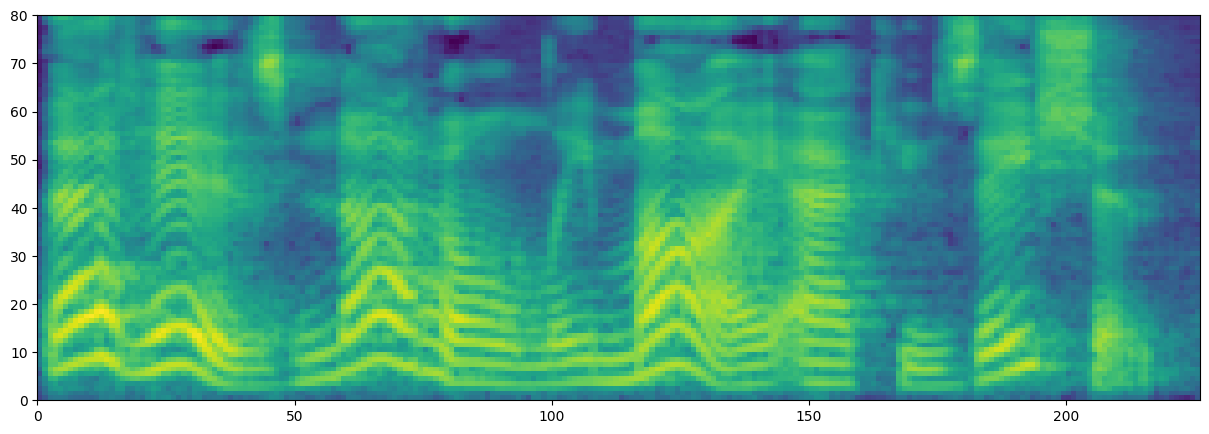

In [8]:
# Plot the spectrogram
plt.figure(figsize=(15,5))
_ = plt.pcolormesh(spec[0].cpu().numpy(), cmap='viridis')

If the above looks like a spectrogram, we can move on to text preprocessing.

### Text Preprocessing

Now, we need to preprocess the text to be passed in to the model. This involves normalization, as well as conversion of the words in the transcript to phonemes where possible. OOV words, as well as words with multiple pronunciations, are ignored and kept as graphemes.

Let's take a look at these steps, one at a time.

In [9]:
# First, a standard English normalization of the text.
# We set punct_post_process=True to preserve words with apostrophes, otherwise they get split.
text_normalized = aligner.normalizer.normalize(text_raw, punct_post_process=True)
print(text_normalized)

That is not only my accusation.


At this point, we could normally just run the normalized text through the model's `tokenizer`, which would run G2P (grapheme to phoneme) conversion and spit out text tokens to pass into the model directly. But just to illustrate what happens within the tokenizer, let's take a look at its G2P step.

*(If you are writing your own inference script, you can leave the code in this next cell out entirely, as it's purely illustrative.)*

In [20]:
# The intermediate G2P step.
# This part is usually hidden behind just calling `tokenizer()`, but we show it here to illustrate what happens.
text_g2p = aligner.tokenizer.g2p(text_normalized)
print(text_g2p)
print(f"Length: {len(text_g2p)}")

['t', 'h', 'a', 't', ' ', 'i', 's', ' ', 'N', 'AA1', 'T', ' ', 'OW1', 'N', 'L', 'IY0', ' ', 'M', 'AY1', ' ', 'a', 'c', 'c', 'u', 's', 'a', 't', 'i', 'o', 'n', '.']
Length: 31


In [34]:
aligner.tokenizer.encode('s')

[0, 44, 16, 0]

We can see that some words have been converted to phonemes (e.g. "not" turned into `["N", "AA1", "T"]`), while some have stayed as graphemes (e.g. "that" is still `["t", "h", "a", "t"]`). As mentioned above, this is because any words with unique and known pronunciations are converted, but other words may have multiple possible pronunciations. CMUdict lists three for "that": `"DH AE1 T"`/`"DH AH0 T"`.

The next cell shows what we'd normally run right after we normalize the text. This gets us our text tokens.

In [11]:
# The tokenizer runs G2P and then encodes each token.
text_tokens = aligner.tokenizer(text_normalized)
print(text_tokens)
print(f"Length: {len(text_tokens)}")

# We need these to be torch tensors with a batch dimension before passing them in as input, of course
text = torch.tensor(text_tokens, device=device).unsqueeze(0).long()
text_len = torch.tensor(len(text_tokens), device=device).unsqueeze(0).long()
print("\nAfter unsqueezing...")
print(f"Text input shape: {text.shape}")
print(f"Text length shape: {text_len.shape}")

[0, 89, 77, 70, 89, 0, 78, 88, 0, 12, 26, 18, 0, 59, 12, 10, 55, 0, 11, 41, 0, 70, 72, 72, 90, 88, 70, 89, 78, 84, 83, 98, 0]
Length: 33

After unsqueezing...
Text input shape: torch.Size([1, 33])
Text length shape: torch.Size([1])


The length increases by 2 if `pad_with_space` was set for the model, which it was for this checkpoint. For ease of lining the results up later, let's update `text_g2p` to reflect this.

In [21]:
# Update text_g2p with spaces
text_g2p.insert(0, ' ')
text_g2p.insert(len(text_g2p), ' ')

Now we have our audio data and encoded text!

## Inference: Alignments and Phoneme Disambiguation

Now that we have the audio and tokenized text, we can pass it through the trained model and get an alignment between the two inputs.

In [22]:
# Run the aligner!
with torch.no_grad():
    attn_soft_tensor, attn_logprob_tensor = aligner(spec=spec, spec_len=spec_len, text=text, text_len=text_len)

# "Unbatch" the results
attn_soft = attn_soft_tensor[0, 0, :, :].data.cpu().numpy()
attn_logprob = attn_logprob_tensor[0, 0, :, :].data.cpu().numpy()

print(f"Dimensions should be (spec_len={spec_len[0].data}, text_len={text_len[0].data}) for both:")
print(f"Soft attention matrix shape: {attn_soft.shape}")
print(f"Log prob matrix shape: {attn_logprob.shape}")

[NeMo W 2024-11-14 00:33:55 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/tts/models/aligner.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    


Dimensions should be (spec_len=226, text_len=33) for both:
Soft attention matrix shape: (226, 33)
Log prob matrix shape: (226, 33)


### Visualizing the Alignments

Now that we have the soft alignments, we can take a look at how the model matches up text tokens and audio input based on the attention matrix generated. This should roughly be a **monotonically decreasing diagonal line** (towards the bottom right).

In the following cell, we transpose the **soft attention matrix** before plotting it in order to show it more "naturally," that is, with the text along the vertical edge (Y-axis) and an increase in the X-axis (left-to-right) value corresponding with moving forward in time through the spectrogram.

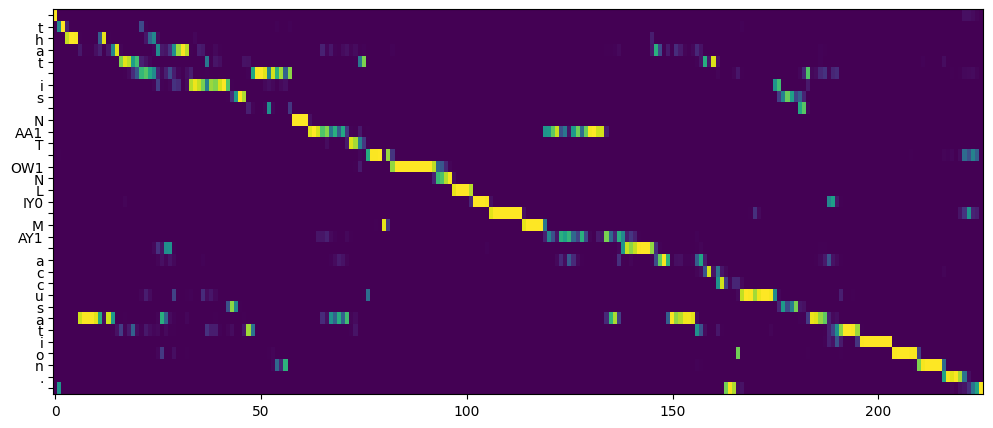

In [23]:
# Visualize soft attention matrix.
fig, ax = plt.subplots(figsize=(12,5))
_ = ax.imshow(attn_soft.transpose(), origin='upper', aspect='auto')
_ = ax.set_yticks(range(len(text_g2p)))
_ = ax.set_yticklabels(text_g2p)  # To show the text labels

The above is a soft attention matrix, so we can see that it is somewhat noisy.

We can calculate a **hard attention matrix** to get more concrete predictions for the durations of each grapheme/phoneme. The next plot should be much sharper. We'll show the spectrogram again so we get a rough idea of what alignments match up with what spectrogram features.

Hard attention matrix shape: (226, 33)


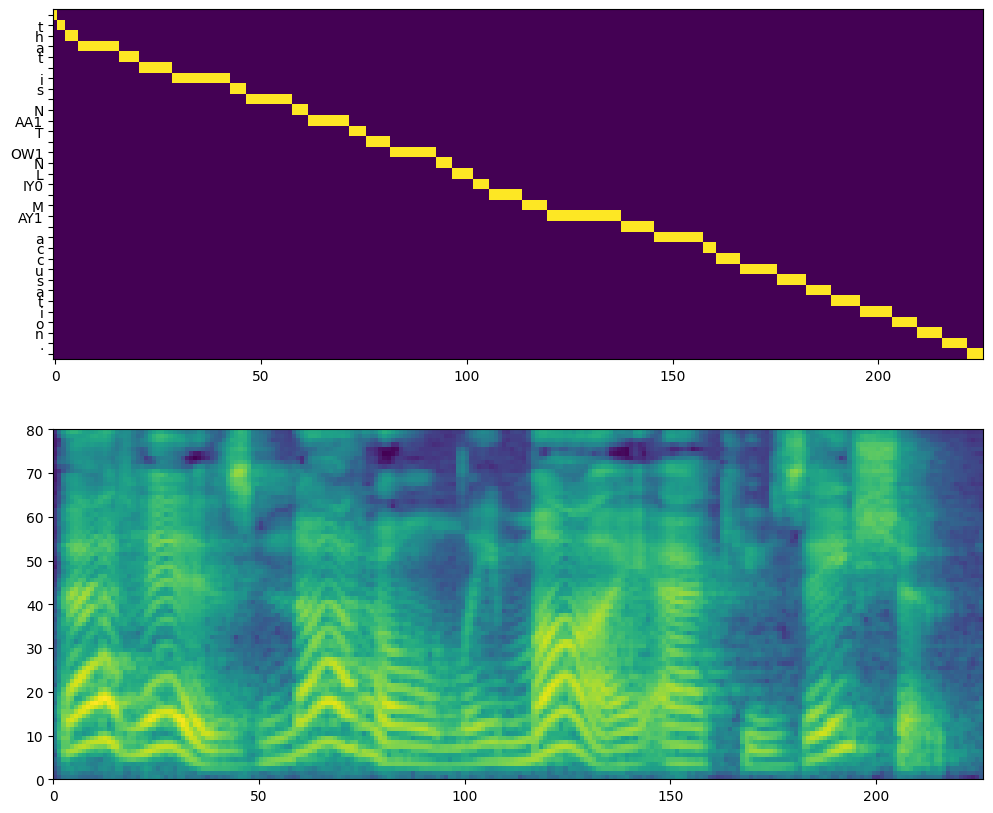

In [24]:
# Import helper function to calculate hard attention
from nemo.collections.tts.parts.utils.helpers import binarize_attention

attn_hard_tensor = binarize_attention(attn_soft_tensor, text_len, spec_len)
attn_hard = attn_hard_tensor[0, 0, :, :].data.cpu().numpy()
print(f"Hard attention matrix shape: {attn_hard.shape}")  # This should be the same as the soft attn matrix shape!

# Now, let's plot the hard attention matrix.
fig, ax = plt.subplots(2, 1, figsize=(12,10))
_ = ax[0].imshow(attn_hard.transpose(), origin='upper', aspect='auto')
_ = ax[0].set_yticks(range(len(text_g2p)))
_ = ax[0].set_yticklabels(text_g2p)  # To show the text labels

# This is the same spectrogram as before, but we show it here just for comparison
_ = ax[1].pcolormesh(spec[0].cpu().numpy(), cmap='viridis')

### Calculating Token Durations

To get the duration (in frames) of each token, we would get the hard attention matrix, then sum up the number of frames that correspond to each token. Luckily, there is a function in the Aligner's encoder module that does this for us!

In [25]:
# Call function to calculate each token's duration in frames
durations = aligner.alignment_encoder.get_durations(attn_soft_tensor, text_len, spec_len).int()

# Let's match them up. (We strip out the first and last duration due to zero-padding.)
durations_sum = 0
for t,d in zip(text_g2p, durations[0]):
    print(f"'{t}' duration: {d}")
    durations_sum += d

# The following should be equal.
print(f"Total number of frames: {spec_len.item()}")
print(f"Sum of durations: {durations_sum}")

' ' duration: 1
't' duration: 2
'h' duration: 3
'a' duration: 10
't' duration: 5
' ' duration: 8
'i' duration: 14
's' duration: 4
' ' duration: 11
'N' duration: 4
'AA1' duration: 10
'T' duration: 4
' ' duration: 6
'OW1' duration: 11
'N' duration: 4
'L' duration: 5
'IY0' duration: 4
' ' duration: 8
'M' duration: 6
'AY1' duration: 18
' ' duration: 8
'a' duration: 12
'c' duration: 3
'c' duration: 6
'u' duration: 9
's' duration: 7
'a' duration: 6
't' duration: 7
'i' duration: 8
'o' duration: 6
'n' duration: 6
'.' duration: 6
' ' duration: 4
Total number of frames: 226
Sum of durations: 226


### Phoneme Disambiguation via Embedding Distance

Remember how some words were not converted in the G2P step, and were kept as graphemes because they had multiple possible pronunciations? It turns out that we can also use a trained Aligner model to make predictions for phoneme disambiguation!

We can do this by:

1. Generating **one text input per possible pronunciation** (e.g. one sentence with `"DH AE1 T"` and one with `"DH AH0 T"`)
2. **Running inference** on each (with the same spectrogram)
3. Calculating the **distance between the text/spectrogram embeddings**
4. Seeing **which disambiguation tokens are closer to the spectrogram**, as determined by the model.

---

Let's get started with our example! As a reminder, the original sentence we've used for this tutorial is:
```
That is not only my accusation.
```

In this sentence, "that," "is," and "accusation" have multiple entries in CMUdict. Each has two possible pronunciations, which means to disambiguate everything, we'd use six inputs:
```
# Disambiguate "that":
DH AE1 T   i s   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .
DH AH0 T   i s   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .

# Disambiguate "is":
t h a t   IH1 Z   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .
t h a t   IH0 Z   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .

# Disambiguate "accusation":
t h a t   i s   N AA1 T   OW1 N L IY0   M AY1   AE2 K Y AH0 Z EY1 SH AH0 N .
t h a t   i s   N AA1 T   OW1 N L IY0   M AY1   AE2 K Y UW0 Z EY1 SH AH0 N .
```

For brevity's sake, let's just disambiguate the word `that`. To create our two candidate inputs, we'll use the `text_g2p` that we generated earlier but cut out the letters from "that" and replace them with our possible pronunciations, then run them through the `EnglishPhonemesTokenizer`'s `encode_from_g2p()` function.

In [26]:
### (1) Generate one text input per possible pronunciation

# Construct our two candidate sentences by replacing "t" "h" "a" "t" with two phonemic possibilities
that1 = ["DH", "AE1", "T"]
that2 = ["DH", "AH0", "T"]
pron1_g2p = that1 + text_g2p[5:-1] # Chop off trailing space, the tokenizer will add it
pron2_g2p = that2 + text_g2p[5:-1] # Ditto.
print("=== Text ===")
print(pron1_g2p)
print(pron2_g2p)

# Tokenize!
pron1_tokens = aligner.tokenizer.encode_from_g2p(pron1_g2p)
pron2_tokens = aligner.tokenizer.encode_from_g2p(pron2_g2p)
print("\n=== Tokens===")
print(pron1_tokens)
print(pron2_tokens)

# Create a batch
disamb_text = torch.tensor([pron1_tokens, pron2_tokens], device=device).long()
disamb_text_len = torch.tensor([len(pron1_tokens), len(pron2_tokens)], device=device).long()
print("\n=== Text/Text Length Tensor Shapes ===")
print(disamb_text.shape)
print(disamb_text_len.shape)

=== Text ===
['DH', 'AE1', 'T', ' ', 'i', 's', ' ', 'N', 'AA1', 'T', ' ', 'OW1', 'N', 'L', 'IY0', ' ', 'M', 'AY1', ' ', 'a', 'c', 'c', 'u', 's', 'a', 't', 'i', 'o', 'n', '.']
['DH', 'AH0', 'T', ' ', 'i', 's', ' ', 'N', 'AA1', 'T', ' ', 'OW1', 'N', 'L', 'IY0', ' ', 'M', 'AY1', ' ', 'a', 'c', 'c', 'u', 's', 'a', 't', 'i', 'o', 'n', '.']

=== Tokens===
[0, 4, 29, 18, 0, 78, 88, 0, 12, 26, 18, 0, 59, 12, 10, 55, 0, 11, 41, 0, 70, 72, 72, 90, 88, 70, 89, 78, 84, 83, 98, 0]
[0, 4, 31, 18, 0, 78, 88, 0, 12, 26, 18, 0, 59, 12, 10, 55, 0, 11, 41, 0, 70, 72, 72, 90, 88, 70, 89, 78, 84, 83, 98, 0]

=== Text/Text Length Tensor Shapes ===
torch.Size([2, 32])
torch.Size([2])


And again, we'll insert a space at the beginning and a space at the end because `pad_with_space` is set to True in the tokenizer.

In [27]:
# Insert spaces to reflect the padded token vector
pron1_g2p.insert(0, ' ')
pron1_g2p.insert(len(pron1_g2p), ' ')
print(len(pron1_g2p))

pron2_g2p.insert(0, ' ')
pron2_g2p.insert(len(pron2_g2p), ' ')
print(len(pron2_g2p))

32
32


Note that we have picked an example where both disambiguations have the same tokenized length (which will be the case most of the time). If you have a case where the two pronunciations have different lengths, you may need to perform some padding to get the batch to line up.

Let's run inference on the new inputs. These two text inputs are candidates for the same spectrogram, so we'll duplicate the spectrogram input.

In [28]:
### (2) Run inference on each candidate

# Duplicate spec and spec_len to match the two text inputs
spec_2 = spec.repeat([2, 1, 1])
spec_len_2 = spec_len.repeat([2])

# Inference with two inputs
with torch.no_grad():
    disamb_attn_soft_tensor, _ = aligner(
        spec=spec_2,
        spec_len=spec_len_2,
        text=disamb_text,
        text_len=disamb_text_len
    )

# "Unbatch" the results
disamb_attn_soft = disamb_attn_soft_tensor[:, 0, :, :].data.cpu().numpy()
print(f"Dimensions should be (2, spec_len={spec_len_2[0].data}, text_len={max(disamb_text_len.data)}):")
print(f"Soft attention matrix shape: {disamb_attn_soft.shape}")

[NeMo W 2024-11-14 00:51:41 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/tts/models/aligner.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    


Dimensions should be (2, spec_len=226, text_len=32):
Soft attention matrix shape: (2, 226, 32)


Next, we retrieve the L2 distance matrix between each text embedding and its corresponding spectrogram embedding. There is an alignment encoder function called `get_dist()` that will calculate $(\texttt{text_emb[i]} - \texttt{spec_emb[j]})^2$ for all pairs of text tokens and spectrogram timesteps, and we can get the L2 distance matrix by square-rooting those values.

(Note that darker = smaller distance, so we should see a dark diagonal of a similar shape to the lines above.)

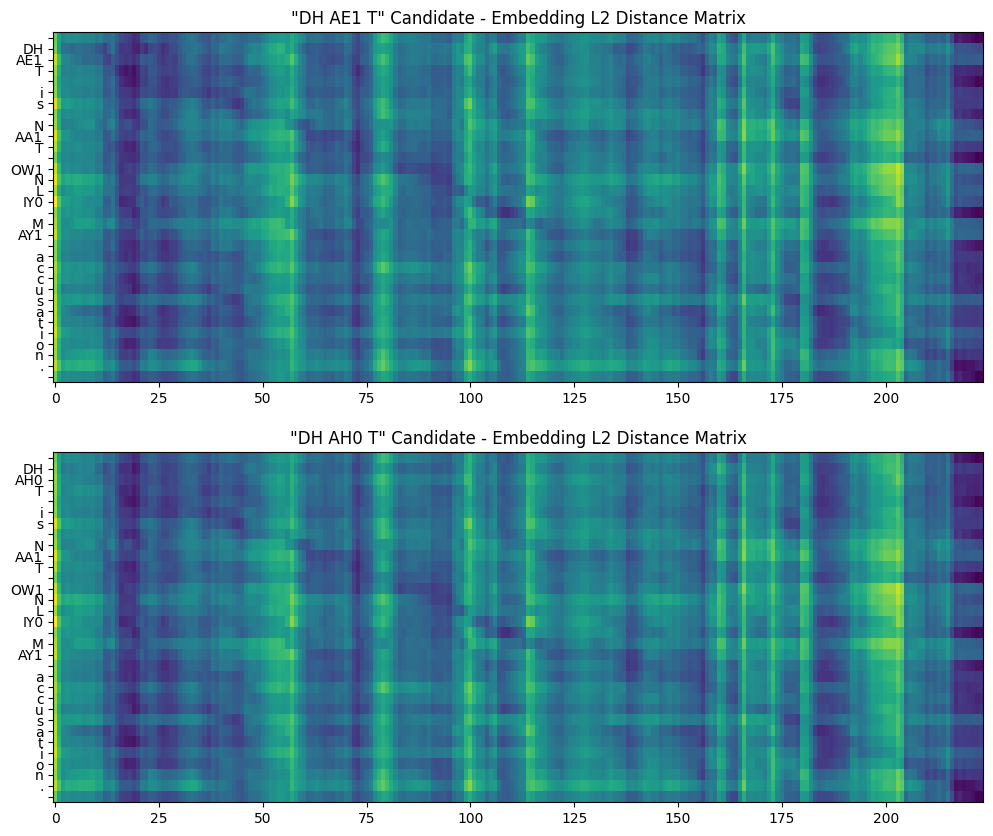

In [29]:
### (3) Calculate distance between text and spectrogram embeddings for each candidate

# Housekeeping: we first need to get the text embedding from the Aligner encoder
disamb_text_embs = aligner.embed(disamb_text).transpose(1,2)

# Run the Aligner encoder to get the distances between the key (text) and query (spectrogram) embeddings.
square_dists = aligner.alignment_encoder.get_dist(keys=disamb_text_embs, queries=spec_2)
l2_dists = square_dists.sqrt()

# We can plot the L2 distances now
l2_dists_data = l2_dists.data.cpu().numpy()
fig, ax = plt.subplots(2, 1, figsize=(12,10))

# Here, we trim the first and last time steps (the zero-padding)
_ = ax[0].imshow(l2_dists_data[0, 1:-1].transpose(), origin='upper', aspect='auto')
_ = ax[0].set_yticks(range(len(pron1_g2p)))
_ = ax[0].set_yticklabels(pron1_g2p)  # To show the text labels
_ = ax[0].set_title("\"DH AE1 T\" Candidate - Embedding L2 Distance Matrix")

_ = ax[1].imshow(l2_dists_data[1, 1:-1].transpose(), origin='upper', aspect='auto')
_ = ax[1].set_yticks(range(len(pron2_g2p)))
_ = ax[1].set_yticklabels(pron2_g2p)
_ = ax[1].set_title("\"DH AH0 T\" Candidate - Embedding L2 Distance Matrix")

The last step is to calculate the average distance between the text tokens for "that" and their corresponding audio frames. **We expect that the candidate pronunciation that's the closest to the audio should be the most representative of the actual speech.**

To do this, we need to get each token's durations, which will let us isolate only the (predicted) frames that correspond to `DH AE1 T` and `DH AH0 T` respectively. Then, the Aligner's encoder has a function called `get_mean_distance_for_word()` that will calculate the average distance over the frames corresponding only to the tokens in the word.

In [30]:
### (4) Check which disambiguation is closer to the speech

# Get durations like before; the batch size of 2 shouldn't change how we call the function.
disamb_durations = aligner.alignment_encoder.get_durations(
    disamb_attn_soft_tensor,
    disamb_text_len,
    spec_len_2
).int()

# Retrieve the average embedding distances for each pronunciation of "that"
that1_mean_dist = aligner.alignment_encoder.get_mean_distance_for_word(
    l2_dists=l2_dists[0],
    durs=disamb_durations[0],
    start_token=1,  # Remember to account for space padding
    num_tokens=len(that1)
)
that2_mean_dist = aligner.alignment_encoder.get_mean_distance_for_word(
    l2_dists=l2_dists[1],
    durs=disamb_durations[1],
    start_token=1,  # Here as well
    num_tokens=len(that2)
)

print(f"Average distance for {that1}: {that1_mean_dist}")
print(f"Average distance for {that2}: {that2_mean_dist}")

Average distance for ['DH', 'AE1', 'T']: 354.1112976074219
Average distance for ['DH', 'AH0', 'T']: 396.1321716308594


And we're done!

**With the average distance for `DH AE1 T` being about 377 and the average distance for `DH AH0 T` being about 403, we can pick `DH AE1 T` as the better match.**

As an exercise, try editing the blocks of code above to disambiguate "accusation" (`AE2 K Y AH0 Z EY1 SH AH0 N` versus `AE2 K Y UW0 Z EY1 SH AH0 N`).

#### Addendum

As a side note, there is also a function called `get_mean_dist_by_durations()` that will match up the distances between each token and its corresponding spectrogram frame (using the previously-calculated durations), then calculate the mean over the batch.

The whole-sentence average may not tell us very much here because we just want to know which pronunciation is closest to what's being said for a specific word, but it's there if you need it as an extra metric!

In [31]:
# Mean distance over the batches:
mean_dists = aligner.alignment_encoder.get_mean_dist_by_durations(
    dist=l2_dists.to('cpu'),
    durations=disamb_durations.to('cpu')
)
print(mean_dists)

tensor([382.5598, 384.8138])


## Resources

- For more information about the Aligner architecture, check out the [RAD-TTS Aligner paper](https://arxiv.org/abs/2108.10447).
- If you would like to run disambiguation on a large batch of sentences, try out the [Aligner disambiguation example script](https://github.com/NVIDIA/NeMo/blob/main/examples/tts/aligner_heteronym_disambiguation.py).

In [36]:
import nemo.collections.tts as nemo_tts

In [37]:
spec_generator = nemo_tts.models.FastPitchModel.from_pretrained("tts_en_fastpitch_ipa").eval()
vocoder = nemo_tts.models.HifiGanModel.from_pretrained(model_name="tts_en_hifigan").eval()

[NeMo I 2024-11-14 01:20:16 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/IPA_1.13.0/files/tts_en_fastpitch_align_ipa.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo
[NeMo I 2024-11-14 01:20:29 common:924] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.
[NeMo W 2024-11-14 01:21:19 deprecated:65] Function ``g2p_backward_compatible_support`` is deprecated. But it will not be removed until a further notice. G2P object root directory `nemo_text_processing.g2p` has been replaced with `nemo.collections.tts.g2p`. Please use the latter instead as of NeMo 1.18.0.
[NeMo W 2024-11-14 01:21:19 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2024-11-14 01:21:20 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2024-11-14 01:21:20 experimental:26] `<class 'nemo.collections.common.

[NeMo I 2024-11-14 01:21:20 features:289] PADDING: 1


[NeMo W 2024-11-14 01:21:21 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-11-14 01:21:22 save_restore_connector:249] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo.
[NeMo I 2024-11-14 01:21:22 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2024-11-14 01:21:39 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-11-14 01:21:43 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2024-11-14 01:21:43 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2024-11-14 01:21:43 features:289] PADDING: 0


[NeMo W 2024-11-14 01:21:43 features:266] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2024-11-14 01:21:43 features:289] PADDING: 0


[NeMo W 2024-11-14 01:21:43 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
      WeightNorm.apply(module, name, dim)
    


[NeMo I 2024-11-14 01:21:47 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [38]:
# helper functions

def generate_audio(input_text):
    # parse() sets phoneme probability to 1, i.e. dictionary phoneme transcriptions are used for known words
    parsed = spec_generator.parse(input_text)
    spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
    audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
    display(ipd.Audio(audio.detach().to('cpu').numpy(), rate=22050))

def display_postprocessed_text(text):
    # to use dictionary entries for known words, not needed for generate_audio() as parse() handles this
    spec_generator.vocab.phoneme_probability = 1
    spec_generator.vocab.g2p.phoneme_probability = 1
    print(f"Input before tokenization: {' '.join(spec_generator.vocab.g2p(text))}\n")

In [39]:
text = "paracetamol can help reduce fever."
generate_audio(text)

In [40]:
display_postprocessed_text(text)
for word in ["paracetamol", "can"]:
    word = word.upper()
    phoneme_forms = spec_generator.vocab.g2p.phoneme_dict[word]
    print(f"Number of phoneme forms for wordPhoneme forms for '{word}': {len(phoneme_forms)} -- {phoneme_forms}")

Input before tokenization: P A R A C E T A M O L   C A N   ˈ h ɛ l p   ɹ ɪ ˈ d u s   ˈ f i v ɚ .

Number of phoneme forms for wordPhoneme forms for 'PARACETAMOL': 0 -- []
Number of phoneme forms for wordPhoneme forms for 'CAN': 2 -- [['ˈ', 'k', 'æ', 'n'], ['k', 'ə', 'n']]


In [41]:
print(f"Original text: {text}")

new_pronunciation = "ˌpæɹəˈsitəmɔl"
phoneme_form = "".join([f"|{s}|" for s in new_pronunciation])
text_with_phonemes = text.replace("paracetamol", phoneme_form)
print(f"Text with phonemes: {text_with_phonemes}")

Original text: paracetamol can help reduce fever.
Text with phonemes: |ˌ||p||æ||ɹ||ə||ˈ||s||i||t||ə||m||ɔ||l| can help reduce fever.


In [42]:
generate_audio(text_with_phonemes)

In [45]:
import os
from nemo.collections.tts.g2p.models.en_us_arpabet import EnglishG2p
from nemo.collections.tts.g2p.models.i18n_ipa import IpaG2p


# EnglishG2p uses the CMU dictionary by default, if none is provided
arpabet_g2p = EnglishG2p()

[NeMo E 2024-11-14 01:28:53 en_us_arpabet:104] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2024-11-14 01:28:53 en_us_arpabet:121] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2024-11-14 01:28:55 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [46]:
text = "Hello world"
arpabet_phonemes = arpabet_g2p(text)

print(text)
print(arpabet_phonemes)

Hello world
['h', 'e', 'l', 'l', 'o', ' ', 'W', 'ER1', 'L', 'D']


In [48]:
print(arpabet_g2p.phoneme_dict['hello'])

[['HH', 'AH0', 'L', 'OW1'], ['HH', 'EH0', 'L', 'OW1']]


In [49]:
arpabet_g2p = EnglishG2p(ignore_ambiguous_words=False)

[NeMo E 2024-11-14 01:29:44 en_us_arpabet:104] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2024-11-14 01:29:44 en_us_arpabet:121] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2024-11-14 01:29:44 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [50]:
text = "Hello world"
arpabet_phonemes = arpabet_g2p(text)

print(text)
print(arpabet_phonemes)

Hello world
['HH', 'AH0', 'L', 'OW1', ' ', 'W', 'ER1', 'L', 'D']


In [51]:
from nemo.collections.tts.torch.tts_tokenizers import EnglishPhonemesTokenizer

arpabet_tokenizer = EnglishPhonemesTokenizer(arpabet_g2p)

In [52]:
text = "Hello world"
arpabet_tokens = arpabet_tokenizer(text)

print(text)
print(arpabet_tokens)

Hello world
[7, 27, 10, 36, 0, 21, 32, 10, 3]
